In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import xtrack as xt
import xpart as xp
import xobjects as xo
from cpymad.madx import Madx

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
mad = Madx()

mad.call('../../../../models/acc-models-ps/scenarios/bare_machine/1_ion_injection_energy/ps_ion_bare_machine.beam')
# This is incorrect, it is for protons
#mad.input("BRHO := BEAM->PC * 3.3356;")

mad.input("BRHO := BEAM->PC * 3.3356 * 208./54.;")

mad.call('../../../../models/acc-models-ps/ps_mu.seq')
mad.call('../../../../models/acc-models-ps/ps_ss.seq')
mad.call('../../../../models/acc-models-ps/scenarios/east/4_slow_extraction/ps_se_east.str')
mad.call("../../../../models/acc-models-ps/_scripts/macros.madx")

mad.input('exec, write_str_file("ps_se_east.str");')

mad.use(sequence='PS')
mad.input('exec, ptc_twiss_macro(2,0,0);')
mad.input('exec, write_ptc_twiss("ps_se_east.tfs")')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.01.10 14:37:52      +
  ++++++++++++++++++++++++++++++++++++++++++++
BEAM, PARTICLE=Pb54, MASS=0.931494*(207.947/208.), CHARGE=54./208., ENERGY=0.931494*(207.947/208.) + .072;

/**********************************************************************************

*

* Elements description and sequence file for each PS main unit (MU).

*

* 07/10/2020 - Alexander Huschauer

************************************************************************************/



/************************************************************************************

*

*         DEFINITION OF FOCUSING AND DEFOCUSING HALF-UNITS OF THE MU               

*

*************************************************************************************/



/******************************************************

True

In [4]:
tw = mad.twiss()

enter Twiss module
  
iteration:   1 error:   1.819621E-03 deltap:   0.000000E+00
orbit:   2.101246E-03  1.661586E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   2.558824E-05 deltap:   0.000000E+00
orbit:   2.091665E-03  1.667237E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.003865E-09 deltap:   0.000000E+00
orbit:   2.091665E-03  1.667237E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02582215501        6.223056701 

                q1                dq1            betxmax              dxmax 
       6.323299708       -4.479147953        32.28796336        11.96341966 

             dxrms             xcomax             xcorms                 q2 
       7.280787512      0.03408032387     0.007371706694        6.218892911 

               dq2            

In [5]:
print(f"{'Horizontal tune:':<18}{tw.summary['q1']:>17.7f}")
print(f"{'Vertical tune:':<18}{tw.summary['q2']:>17.7f}")
print(f"{'Magnetic rigidity:':<18}{mad.eval('BRHO'):>17.7f}")

Horizontal tune:          6.3232997
Vertical tune:            6.2188929
Magnetic rigidity:        4.7950777


In [6]:
damper = mad.sequence().expanded_elements['pr.kfb97']
kfb_twiss = tw.dframe().loc[tw.dframe().name.str.startswith(damper.name)]

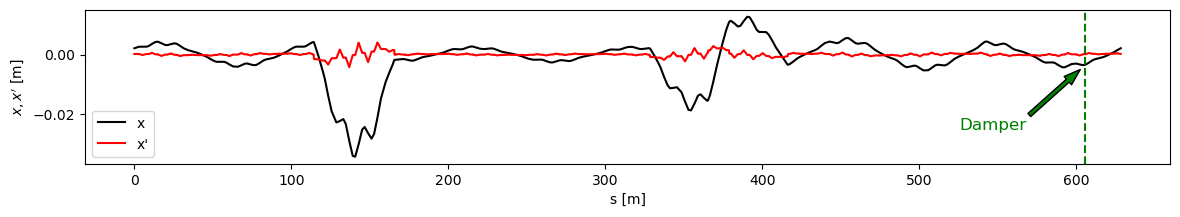

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
ax.plot(tw.s, tw.x, 'k', label='x')
ax.plot(tw.s, tw.px, 'r', label='x\'')
ax.axvline(kfb_twiss.s[0], color='g', linestyle='--')
ax.annotate('Damper', (kfb_twiss.s[0]-3, -0.005), (kfb_twiss.s[0]-80, -0.025), arrowprops={'width': 3, 'headwidth': 8, 'facecolor': 'green'}, color='g', size=12)
ax.set_xlabel('s [m]')
ax.set_ylabel(r'$x, x^\prime$ [m]')
ax.legend()

In [8]:
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
twiss_initial = mad.twiss(file="slow_extraction.tfs").dframe()


enter Twiss module
  
iteration:   1 error:   1.819621E-03 deltap:   0.000000E+00
orbit:   2.101246E-03  1.661586E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   2.558824E-05 deltap:   0.000000E+00
orbit:   2.091665E-03  1.667237E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.003865E-09 deltap:   0.000000E+00
orbit:   2.091665E-03  1.667237E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02582215501        6.223056701 

                q1                dq1            betxmax              dxmax 
       6.323299708       -4.479147953        32.28796336        11.96341966 

             dxrms             xcomax             xcorms                 q2 
       7.280787512      0.03408032387     0.007371706694        6.218892911 

               dq2            

In [9]:
 ### Cycle sequence, changing starting point and adding markers at around the magnet 62
mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')
mad.use(sequence = "PS")
mad.input('savebeta, label=bumped23, place = PR.BPM23;')
twiss_cycled_raw = mad.twiss()
twiss_cycled = twiss_cycled_raw.dframe()

++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
enter Twiss module
  
iteration:   1 error:   5.603511E-02 deltap:   0.000000E+00
orbit:  -3.149127E-02 -1.169344E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   2.062934E-03 deltap:   0.000000E+00
orbit:  -3.379506E-02 -1.891997E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   6.214711E-06 deltap:   0.000000E+00
orbit:  -3.379558E-02 -1.889973E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   4 error:   5.115029E-11 deltap:   0.000000E+00
orbit:  -3.379558E-02 -1.889974E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0  

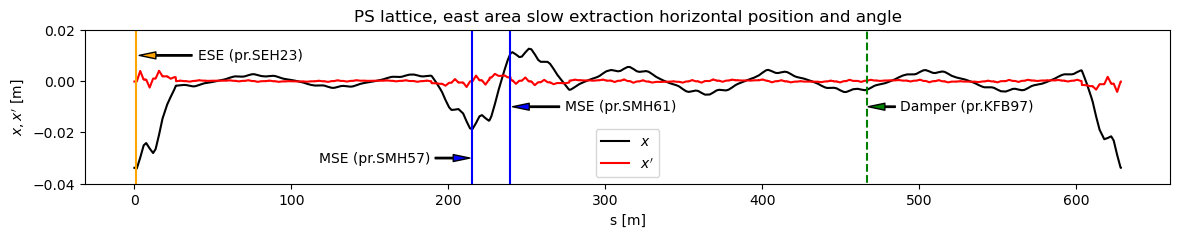

In [10]:
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(twiss_cycled.s, twiss_cycled.x, 'k', label=r'$x$')
ax.plot(twiss_cycled.s, twiss_cycled.px, 'r', label=r'$x^\prime$')
ax.set_ylim(-0.040,0.020)
ax.set_xlabel('s [m]')
ax.set_ylabel(r'$x, x^\prime$ [m]')

kfb_twiss_cycled = twiss_cycled.loc[twiss_cycled.name.str.startswith(damper.name)]

ax.vlines(twiss_cycled.s["pe.seh23"],-0.1,0.1, color="orange")
ax.vlines(twiss_cycled.s["pe.smh57"],-0.1,0.1, color="blue")
ax.vlines(twiss_cycled.s["pe.smh61"],-0.1,0.1, color="blue")
ax.vlines(twiss_cycled.s["pr.kfb97"],-0.1,0.1, color="green", linestyle="--")
ax.annotate('ESE (pr.SEH23)',
        xy=(twiss_cycled.s["pe.seh23"], 0.01), xycoords='data',
        xytext=(120, 0), textcoords='offset points',
        arrowprops=dict(facecolor='orange', shrink=0.05, headwidth=5, width=1),
        horizontalalignment='right', verticalalignment='center')
ax.annotate('MSE (pr.SMH57)',
        xy=(twiss_cycled.s["pe.smh57"], -0.03), xycoords='data',
        xytext=(-30, 0), textcoords='offset points',
        arrowprops=dict(facecolor='blue', shrink=0.05, headwidth=5, width=1),
        horizontalalignment='right', verticalalignment='center')
ax.annotate('MSE (pr.SMH61)',
        xy=(twiss_cycled.s["pe.smh61"], -0.01), xycoords='data',
        xytext=(120, 0), textcoords='offset points',
        arrowprops=dict(facecolor='blue', shrink=0.05, headwidth=5, width=1),
        horizontalalignment='right', verticalalignment='center')
ax.annotate('Damper (pr.KFB97)',
        xy=(twiss_cycled.s["pr.kfb97"], -0.01), xycoords='data',
        xytext=(120, 0), textcoords='offset points',
        arrowprops=dict(facecolor='green', shrink=0.05, headwidth=5, width=1),
        horizontalalignment='right', verticalalignment='center')
ax.set_title("PS lattice, east area slow extraction horizontal position and angle")
ax.legend()

# Tracking

In [11]:
 #### First Turn
mad.input('savebeta, label=after_first_turn, place = pspr.bpm23_p_;')
twiss_se_first_turn_raw = mad.twiss(beta0 = "bumped23")
twiss_se_first_turn = twiss_se_first_turn_raw.dframe()

#### Second turn
mad.input('savebeta, label=after_second_turn, place = pspr.bpm23_p_;')
twiss_se_second_turn_raw = mad.twiss(beta0 = "after_first_turn")
twiss_se_second_turn = twiss_se_second_turn_raw.dframe()

mad.input('savebeta, label=after_third_turn, place = pspr.bpm23_p_;')
#### Third turn
twiss_se_third_turn_raw = mad.twiss(beta0 = "after_second_turn")
twiss_se_third_turn = twiss_se_third_turn_raw.dframe()

enter Twiss module
 Found 6 initial orbit vector values from twiss command. 
  
open line - error with deltap:   0.000000E+00
initial orbit vector:  -3.379558E-02 -1.889974E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:    -3.379558E-02 -1.889974E-04  0.000000E+00  0.000000E+00  2.851309E-02  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       6.323299708                  0        32.28796336        11.96341966 

             dxrms             xcomax             xcorms                 q2 
       7.279539542      0.03408032387     0.007414528793        6.218892911 

               dq2            betymax              dymax              dyrms 
                 0        30.05929481                  0                  0 

            ycomax 

In [31]:
for item in twiss_se_first_turn_raw.summary:
    print(f'{item:<15}', twiss_se_first_turn_raw.summary[item])

sequence        PS
particle        PB54
mass            0.9312566482
charge          0.2596153846
energy          1.003256648
pc              0.3732089995
gamma           1.077314884
kbunch          1.0
bcurrent        1.057867738e-14
sige            0.001
sigt            1.0
npart           1.0
ex              1.0
ey              1.0
et              0.001
bv_flag         1.0
length          628.3185
alfa            0.0
orbit5          -0.05702618635
gammatr         0.0
q1              18.96989912
q2              18.65667873
dq1             0.0
dq2             0.0
dxmax           11.96341966
dymax           0.0
xcomax          0.03408032387
ycomax          0.0
betxmax         32.28796336
betymax         30.05929481
xcorms          0.007414528793
ycorms          0.0
dxrms           7.279539542
dyrms           0.0
deltap          0.0
synch_1         0.0
synch_2         0.0
synch_3         0.0
synch_4         0.0
synch_5         0.0
synch_6         0.0
synch_8         0.0
dqmin           

In [22]:
print(f"{'first turn':<14}{twiss_se_first_turn_raw.summary['q1']:.6f}\t\t{twiss_se_first_turn_raw.summary['q2']:.6f}")
print(f"{'second turn':<14}{twiss_se_second_turn_raw.summary['q1']:.6f}\t\t{twiss_se_second_turn_raw.summary['q2']:.6f}")
print(f"{'third turn':<14}{twiss_se_third_turn_raw.summary['q1']:.6f}\t\t{twiss_se_third_turn_raw.summary['q2']:.6f}")

first turn    18.969899		18.656679
second turn   18.969899		18.656679
third turn    18.969899		18.656679


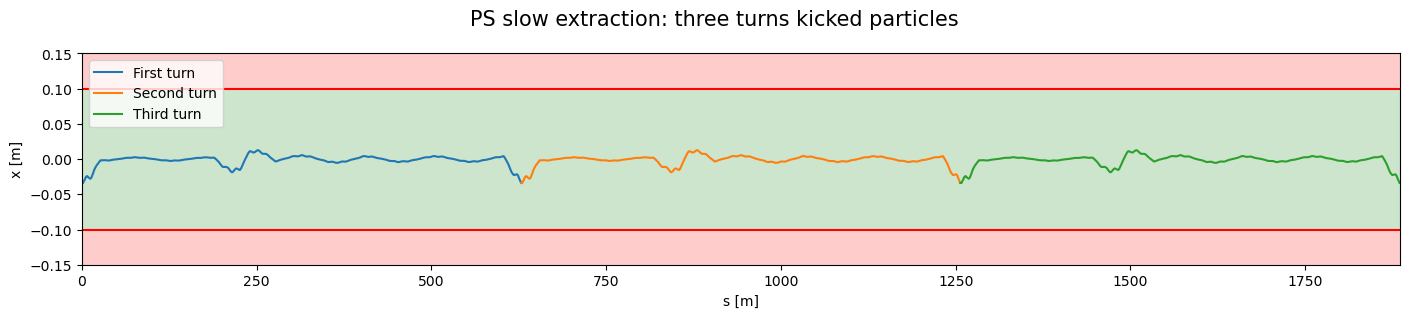

In [12]:
len_ps = twiss_initial.s[-1] 

fig, ax = plt.subplots(figsize=(14,3))
fig.suptitle(f'PS slow extraction: three turns kicked particles', fontsize=15)
ax.plot(twiss_se_first_turn.s+0*len_ps, twiss_se_first_turn.x, label = "First turn")
ax.plot(twiss_se_second_turn.s+1*len_ps, twiss_se_second_turn.x, label = "Second turn")
ax.plot(twiss_se_third_turn.s+2*len_ps, twiss_se_third_turn.x, label = "Third turn")
ax.legend(loc ="upper left")
plt.tight_layout()
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.set_ylim(-0.15,0.15)
ax.set_xlim(0,3*len_ps)

ax.axhline(y=+0.1, color = "r")
ax.axhline(y=-0.1, color = "r")

ax.axhspan(0.1, 0.15, facecolor="r", alpha=0.2)
ax.axhspan(0.1, -0.1, facecolor="g", alpha=0.2)
ax.axhspan(-0.1, -0.15, facecolor="r", alpha=0.2)

In [13]:
pfw_dict = {'k1prpfwf': 0.0003384900992457131,
 'k1prpfwd': -0.0005501033978386092,
 'k2prpfwf': 0.005584849501798299,
 'k2prpfwd': -0.016767529852205507}

In [19]:
from pybt.tools.parsers import read_twiss_file

header_read, twiss_read = read_twiss_file('slow_extraction.tfs')
gamma = header_read["gamma"]
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
p = 24 # beam momentum (GeV/c)
Brho = 24*3.3356
#Brho = 4.79507769040906
PS_radius = 70.079

In [20]:
### First turn with SEH23
# Initialise Septum strength
mad.input('PE.SEH23 , KICK := kPESEH23')
mad.input('PE.SMH57 , KICK := kPESMH57')
mad.input('PE.SMH61 , KICK := kPESMH61')
mad.input('kPESEH23 = 0.0;')
mad.input('kPESMH57 = 0.0;')
mad.input('kPESMH61 = 0.0;')

# # Default PFW from Alex
# mad.input("k1prpfwf           =   -0.0001009094244 ;")
# mad.input("k1prpfwd           =    5.894593051e-05 ;")
# mad.input("k2prpfwf           =    -0.002222356465 ;")
# mad.input("k2prpfwd           =    -0.003987126033 ;")

# Change tune to be on resonance       
mad.input("k1prpfwf = "+str(pfw_dict["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict["k2prpfwd"])+";")

# Electrostatic septum strength
voltage_seh23 = -177e3 # [V]
gap_seh23 = (88.11-73.00)/1000 # [m]
Efield = voltage_seh23/gap_seh23
effective_length = 0.8 # [m]
seh23_strength = np.arctan( (abs(Efield)*effective_length)/ (p*1e9*beta) )
mad.input('kPESEH23 = '+str(seh23_strength)+';')

mad.use(sequence = "PS")
mad.input('savebeta, label=after_first_turn, place = pspr.bpm23_p_;')
twiss_se_first_turn = mad.twiss(beta0 = "bumped23", x=-0.075, px=-0.0015).dframe()

#### Second turn
mad.input('kPESEH23 = '+str(0.0)+';') # Turn off electrostatic septum
mad.input('savebeta, label=after_second_turn, place = pspr.bpm23_p_;')
twiss_se_second_turn = mad.twiss(beta0 = "after_first_turn").dframe()

#### Third turn
# Magnetic septums strength
smh57_current = 9120                                # Measurement on 12.11.21
smh57_strength = (smh57_current*(378e-3/9871))/Brho # Scaling from codilog
smh61_current = 1170                                # Measurement on 12.11.21
smh61_strength = (smh61_current*(0.247/2350))/Brho  # Scaling from codilog
mad.input('kPESEH23 = 0.0;')
mad.input('kPESMH57 = '+str(smh57_strength)+';')
mad.input('kPESMH61 = '+str(smh61_strength)+';')
twiss_se_third_turn = mad.twiss(beta0 = "after_second_turn").dframe()

++++++ info: kpeseh23 redefined
++++++ info: kpesmh57 redefined
++++++ info: kpesmh61 redefined
++++++ info: k1prpfwf redefined
++++++ info: k1prpfwd redefined
++++++ info: k2prpfwf redefined
++++++ info: k2prpfwd redefined
++++++ info: kpeseh23 redefined
enter Twiss module
 Found 6 initial orbit vector values from twiss command. 
  
open line - error with deltap:   0.000000E+00
initial orbit vector:  -7.500000E-02 -1.500000E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:    -1.590887E-02  1.343677E-03  0.000000E+00  0.000000E+00  4.214543E-02  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       6.282834527                  0         33.1145585        15.23501984 

             dxrms             xcomax             xcorms                 

NameError: name 'len_ps' is not defined

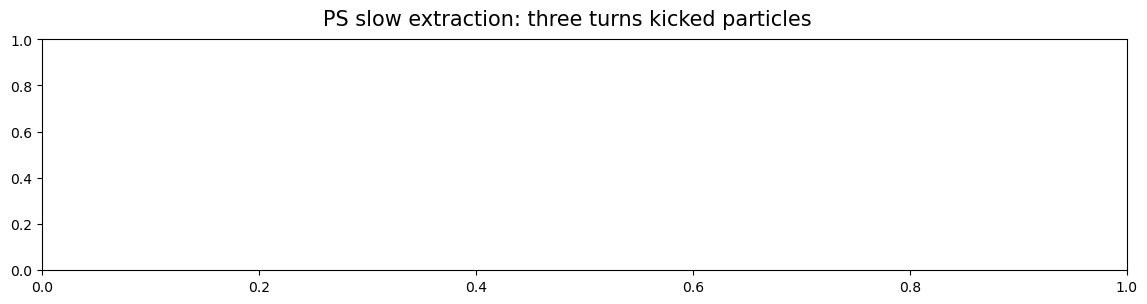

In [32]:
fig, ax = plt.subplots(figsize=(14,3))
fig.suptitle(f'PS slow extraction: three turns kicked particles', fontsize=15)
ax.plot(twiss_se_first_turn.s+0*len_ps, twiss_se_first_turn.x, label = f"First turn")
ax.plot(twiss_se_second_turn.s+1*len_ps, twiss_se_second_turn.x, label = "Second turn")
ax.plot(twiss_se_third_turn.s+2*len_ps, twiss_se_third_turn.x, label = "Third turn")
ax.legend(loc ="upper left")
plt.tight_layout()
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.set_ylim(-0.15,0.15)
ax.set_xlim(0,3*len_ps)

ax.axhline(y=+0.1, color = "r")
ax.axhline(y=-0.1, color = "r")

ax.axhspan(0.1, 0.15, facecolor="r", alpha=0.2)
ax.axhspan(0.1, -0.1, facecolor="g", alpha=0.2)
ax.axhspan(-0.1, -0.15, facecolor="r", alpha=0.2)